# Spatial Metabolomics - Medulablastoma Project: 9aa matrix

The below code is all code used to analyse the 9aa MALDI matrix data

Author: Andrew Causer (uqacause@uq.edu.au)

## Load Required Packages

To peform all the analysis in the script below we require some specialised packages:

In [2]:
suppressWarnings ({

    #This is a custom package that has been downloaded from: devtools::install_github("agc888/SpaMTP")
    library(SpaMTP) 
    
    #General Libraries
    library(Cardinal)
    library(Seurat)

    #For plotting + DE plots
    library(ggplot2)
    library(EnhancedVolcano)
    library(ggplotify)
})

## Load Data

We first need to set our working directories and then load our Spatial Metabolomic data. We will load the data using *Cardinal*

In [4]:
DATA_DIR <- "/QRISdata/Q5291/VLP94_MALDI/2023_10_01_tissue_regions_imzml_file/"
OUT_DIR  <- "/QRISdata/Q1851/Andrew_C/Metabolomics/MedulaBlastoma/9aa/"

In [5]:
C1 <- readImzML("vlp94a-9aa-tissue region",folder = DATA_DIR, mass.range = c(160,1500), resolution = 10)
T1 <- readImzML("vlp94c-9aa-tissue region",folder = DATA_DIR, mass.range = c(160,1500), resolution = 10)
C2 <- readImzML("vlp94b-9aa-tissue region",folder = DATA_DIR, mass.range = c(160,1500), resolution = 10)
T2 <- readImzML("vlp94d-9aa-tissue region",folder = DATA_DIR, mass.range = c(160,1500), resolution = 10)

## Merge all samples into one Cardinal Object

By merging the data together into one object we can compare/plot them together between <span style = "color: blue;">**Control**</span> and <span style = "color: red;">**Treated**</span> conditions

In [12]:
## Merge Data into one Cardinal Object (used for ssc annotation)
data_9aa <- MergeCardinalData(list(C1, T1, C2, T2), shift.image = FALSE)

Setting Centroids as TRUE ...... 



## Import sample segmentation clusters (SSC data)

We previously ran spatial srunken centroid (ssc) analysis using *Cardinal* to segment/cluster each sample using the 9aa data matrix. We will import the data, visualise it and then add the s = 25 resolution results to our merged data object

In [7]:
#read ssc cardinal object
data_ssc_9aa <- readRDS("/QRISdata/Q1851/Andrew_C/Metabolomics/9aa/All_Samples_ssc.RDS")

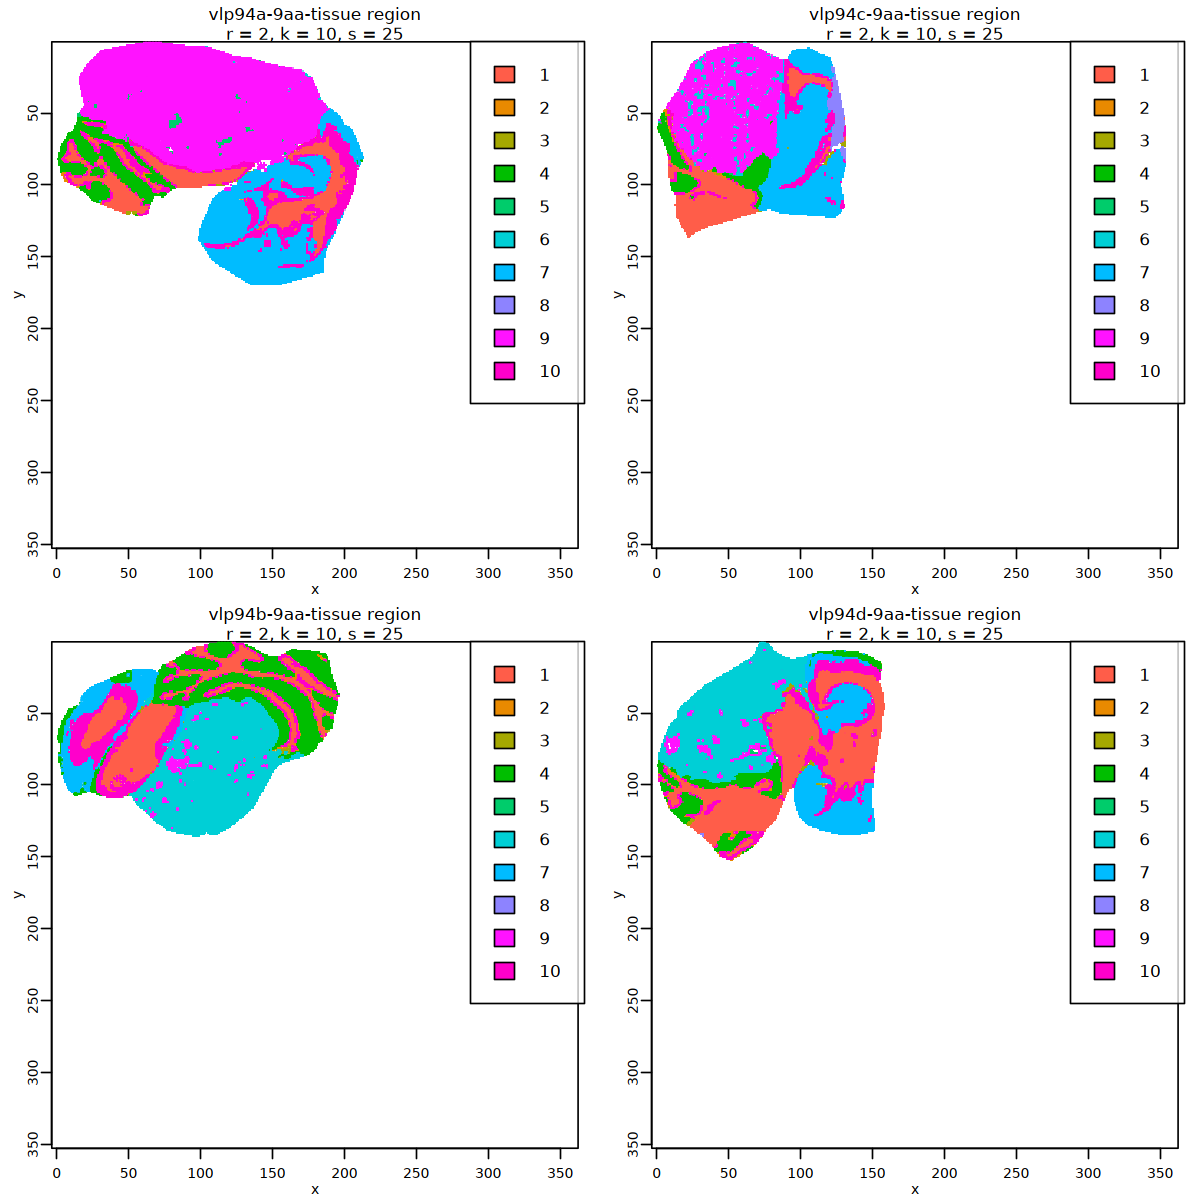

In [8]:
options(repr.plot.width = 10, repr.plot.height = 10)

image(data_ssc_9aa, model=list(s=c(25)))

In [13]:
## adds clusters to the merged object
test_9aa <- add_ssc_annotation(data_9aa, data_ssc_9aa, resolution = 25)

Getting cluster segments for resolution (s) = 25



## Convert Cardinal object to a Seurat object

This will allow us to visualise the data easer and also use other downstream analysis tools that are also compatible with seurat

In [ ]:
C1_seurat_9aa <- CardinalToSeurat(test_9aa,"vlp94a-9aa-tissue region")
T1_seurat_9aa <- CardinalToSeurat(test_9aa,"vlp94c-9aa-tissue region")
C2_seurat_9aa <- CardinalToSeurat(test_9aa,"vlp94b-9aa-tissue region")
T2_seurat_9aa <- CardinalToSeurat(test_9aa,"vlp94d-9aa-tissue region")

Convering Cardinal object to Seurat object .... 

Generating Seurat Barcode Labels from Pixel Coordinates .... 

Constructing Seurat Object ....

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Adding Pixel Metadata ....

Creating Centroids for Spatial Seurat Object ....

Convering Cardinal object to Seurat object .... 

Generating Seurat Barcode Labels from Pixel Coordinates .... 

Constructing Seurat Object ....

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Adding Pixel Metadata ....

Creating Centroids for Spatial Seurat Object ....

Convering Cardinal object to Seurat object .... 

Generating Seurat Barcode Labels from Pixel Coordinates .... 

Constructing Seurat Object ....



## Annotate m/z weights using Reference LIPID_DB

Lets process the data and annotate the m/z weights using the LIPID_DB provided by *SpaMTP*

In [ ]:
# Normalise the data objects using TIC normalisation
C1_seurat_9aa <- NormalizeSeuratData(C1_seurat_9aa)
T1_seurat_9aa <- NormalizeSeuratData(T1_seurat_9aa)
C2_seurat_9aa <- NormalizeSeuratData(C2_seurat_9aa)
T2_seurat_9aa <- NormalizeSeuratData(T2_seurat_9aa)

In [ ]:
#Annotate each sample using the Lipid database
T1_9aa <- AnnotateSeuratMALDI(T1_seurat_9aa, HMDB_db) 
C1_9aa <- AnnotateSeuratMALDI(C1_seurat_9aa, HMDB_db)
T2_9aa <- AnnotateSeuratMALDI(T2_seurat_9aa, HMDB_db)
C2_9aa <- AnnotateSeuratMALDI(C2_seurat_9aa, HMDB_db)

### Save Data

This data is quit large and takes time to process, lets save it so its easy to load next time

In [ ]:
#save individual objects
saveRDS(T1_9aa, paste0(OUT_DIR,"data_objects/T1_9aa.RDS"))
saveRDS(C1_9aa, paste0(OUT_DIR,"data_objects/C1_9aa.RDS"))
saveRDS(T2_9aa, paste0(OUT_DIR,"data_objects/T2_9aa.RDS"))
saveRDS(C2_9aa, paste0(OUT_DIR,"data_objects/C2_9aa.RDS"))

## Find Differentially Expressed m/z Peaks

Now that we have annotated our m/z values we will peform DEP analysis. First we need to subset our data to just look at the tumour regions between the <span style = "color: blue;">**Control**</span> and <span style = "color: red;">**Treated**</span> samples.

In [ ]:
# Labels each sample according to their treatment group, this is required for subsetting
T1_9aa_annotated@meta.data$treatment <- "Treated"
C1_9aa_annotated@meta.data$treatment <- "Control"
T2_9aa_annotated@meta.data$treatment <- "Treated"
C2_9aa_annotated@meta.data$treatment <- "Control"

We also need to find which segmentation clusters match the tumour region. Based on the plots below these clusters are: 5, 6 and 9

In [ ]:
image(data_ssc_9aa, model=list(s=c(25)), column=c(6,9,5))

lets now subset the data and run DE!

In [ ]:
# Makes a column which contains which spots are in the tumour region of interest
T1_9aa_annotated@meta.data$tumour <- ifelse((T1_9aa_annotated@meta.data$ssc == 5 |T1_9aa_annotated@meta.data$ssc == 6 |T1_9aa_annotated@meta.data$ssc == 9), TRUE, FALSE)
C1_9aa_annotated@meta.data$tumour <- ifelse((C1_9aa_annotated@meta.data$ssc == 5 |C1_9aa_annotated@meta.data$ssc == 6|C1_9aa_annotated@meta.data$ssc == 9), TRUE, FALSE)
T2_9aa_annotated@meta.data$tumour <- ifelse((T2_9aa_annotated@meta.data$ssc == 5 |T2_9aa_annotated@meta.data$ssc == 6 |T2_9aa_annotated@meta.data$ssc == 9), TRUE, FALSE)
C2_9aa_annotated@meta.data$tumour <- ifelse((C2_9aa_annotated@meta.data$ssc == 5 |C2_9aa_annotated@meta.data$ssc == 6 |C2_9aa_annotated@meta.data$ssc == 9), TRUE, FALSE)

In [ ]:
# Merges all data into one object for DE
all_data_9aa <- JoinLayers(merge(T1_9aa_annotated, y=list(C1_9aa_annotated,T2_9aa_annotated,C2_9aa_annotated), merge.data = TRUE))

In [ ]:
# Subsets the data to just the tumour region
Idents(all_data_9aa) <- "tumour"
tumour <- subset(all_data_9aa, idents = TRUE)

In [ ]:
tumour_9aa_DEPs <- FindAllDEPs(tumour, "treatment", n = 3, logFC_threshold = 1.2, 
                           run_name = "FindAllDEPs", 
                           annotation.column = "all_IsomerNames")